In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix,
                             classification_report, roc_auc_score, roc_curve, auc)
import joblib
import os

sns.set(style="whitegrid")

In [2]:
# loaded datasets 
FILE = "Churn.csv"
df = pd.read_csv(FILE)
print("Loaded:", FILE, "| shape:", df.shape)
display(df.head())

Loaded: Churn.csv | shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Normalize columns names 
df.columns = df.columns.str.strip().str.lower()

In [4]:
# detect target columns 
possible_targets = [c for c in df.columns if c in  ['churn', 'is_churn', 'churned', 'target', 'default']]
if possible_targets:
    target_col = possible_targets[0]
else:
     # fallback: last column
    target_col = df.columns[-1]
    print(f"Warning: Could not find common target name. Using last column as target: '{target_col}'")

print("Target column selected:", target_col)

Target column selected: churn


In [5]:
# basic cleaning 
# drop duplicates 
df = df.drop_duplicates()

# Convert numeric-like columns stored as strings to numeric if possible
for col in df.columns:
    if df[col].dtype == 'object':
        # try to convert numbers with commas/spaces
        cleaned = df[col].str.replace(',','').str.strip()
        try:
            df[col] = pd.to_numeric(cleaned)
        except Exception:
            pass
            

In [6]:
# Identify numeric and categorical lists
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in num_cols and c != target_col]

# If target is object, encode it to 0/1
if df[target_col].dtype == 'object':
    le_t = LabelEncoder()
    df[target_col] = le_t.fit_transform(df[target_col].astype(str))
    print("Encoded target labels:", list(le_t.classes_))

Encoded target labels: ['No', 'Yes']


In [7]:
# # Fill numeric missing with median, categorical with mode
for c in num_cols:
    if df[c].isnull().sum() > 0:
        df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    if df[c].isnull().sum() > 0:
        df[c] = df[c].fillna(df[c].mode().iloc[0])

print("\nAfter cleaning: shape:", df.shape)
print("Numeric cols:", num_cols)
print("Categorical cols (sample):", cat_cols[:10])


After cleaning: shape: (7043, 21)
Numeric cols: ['seniorcitizen', 'tenure', 'monthlycharges', 'totalcharges']
Categorical cols (sample): ['customerid', 'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection']


In [8]:
# # 5) Feature engineering (create 3 new useful features)
# We'll try to detect tenure and total/monthly charges common names
tenure_candidates = [c for c in df.columns if 'tenure' in c or c=='tenure_months' or c=='tenure_month']
tenure_col = tenure_candidates[0] if tenure_candidates else None

monthly_candidates = [c for c in df.columns if 'monthly' in c and ('charge' in c or 'amount' in c)]
monthly_col = monthly_candidates[0] if monthly_candidates else None

total_candidates = [c for c in df.columns if 'total' in c and ('charge' in c or 'amount' in c)]
total_col = total_candidates[0] if total_candidates else None

print("\nDetected columns - tenure:", tenure_col, "monthly:", monthly_col, "total:", total_col)


Detected columns - tenure: tenure monthly: monthlycharges total: totalcharges


In [9]:
# # Feature 1: monthly_avg_spend (prefer total/tenure -> else use monthly_col)
if total_col and tenure_col and df[tenure_col].notna().sum()>0:
    df['monthly_avg_spend'] = df[total_col] / (df[tenure_col].replace(0, np.nan))
    df['monthly_avg_spend'] = df['monthly_avg_spend'].fillna(df[monthly_col] if monthly_col else 0)
elif monthly_col:
    df['monthly_avg_spend'] = df[monthly_col]
else:
    # fallback: create from numeric spend-like columns if available or random small
    spend_candidates = [c for c in df.columns if c in ['amount','payment','balance','bill','charges']]
    if spend_candidates:
        df['monthly_avg_spend'] = df[spend_candidates[0]]
    else:
        df['monthly_avg_spend'] = 0.0
print("Feature created: monthly_avg_spend")

Feature created: monthly_avg_spend


In [10]:
# feature 2: high_vol_flag 
base_for_log = total_col if total_col else 'monthly_avg_spend'
df['log_total'] = np.log1p(df[base_for_log].abs())  # log transform(handles zero/neg)
print("Feature Created: log_total (from {})".format(base_for_log))

Feature Created: log_total (from totalcharges)


In [11]:
# Optional Feature 4: tenure_bucket (if tenure present)
if tenure_col:
    df['tenure_bucket'] = pd.cut(df[tenure_col], bins=[-1,3,12,24,60,1000], labels=['0-3','4-12','13-24','25-60','60+'])
    print("Feature created: tenure_bucket")

Feature created: tenure_bucket


In [12]:
# Prepare data for modeling
# encode categorical columns 
# 6) Prepare data for modeling
# Encode categorical columns (including tenure_bucket if present)
model_df = df.copy()
enc_cols = [c for c in model_df.columns if model_df[c].dtype == 'object' or str(model_df[c].dtype).startswith('category')]
enc_cols = [c for c in enc_cols if c != target_col]  # exclude target
for c in enc_cols:
    model_df[c] = LabelEncoder().fit_transform(model_df[c].astype(str))

In [13]:
# Select features: baseline (original numeric features except target) and engineered (adds new features)
# baseline features: numeric columns minus target
baseline_features = [c for c in num_cols if c != target_col]
# drop any id-like columns (very large unique)
id_like = [c for c in baseline_features if model_df[c].nunique() > (0.9 * len(model_df))]
baseline_features = [c for c in baseline_features if c not in id_like]

In [14]:
# engineered features to add 
eng_features = ['monthly_avg_spend','is_high_value','log_total']
if 'tenure_bucket' in model_df.columns:
    eng_features.append('tenure_bucket')

In [15]:
# ensure feature exist in model_df
baseline_features = [c for c in baseline_features if c in model_df.columns]
eng_features = [c for c in eng_features if c in model_df.columns]

print("\nBaseline features count:", len(baseline_features))
print("Engineered features:", eng_features)


Baseline features count: 3
Engineered features: ['monthly_avg_spend', 'log_total', 'tenure_bucket']


In [16]:
# Build X,y for baseline and engineered
X_base = model_df[baseline_features].fillna(0)
X_eng = pd.concat([X_base, model_df[eng_features].fillna(0)], axis=1)
y = model_df[target_col].astype(int)

# Scale features
scaler = StandardScaler()
Xb_scaled = scaler.fit_transform(X_base)
Xe_scaled = scaler.fit_transform(X_eng)

In [17]:
# 7) Train-test split (stratify to keep class balance)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb_scaled, y, test_size=0.2, random_state=42, stratify=y)
Xe_train, Xe_test, ye_train, ye_test = train_test_split(Xe_scaled, y, test_size=0.2, random_state=42, stratify=y) 

In [18]:
# 8) Baseline model (RandomForest default)
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(Xb_train, yb_train)
yb_pred = rf_base.predict(Xb_test)
yb_prob = rf_base.predict_proba(Xb_test)[:,1]

print("\n=== Baseline Model Evaluation ===")
print("Accuracy:", round(accuracy_score(yb_test, yb_pred),4))
print("F1 Score:", round(f1_score(yb_test, yb_pred),4))
try:
    print("ROC AUC:", round(roc_auc_score(yb_test, yb_prob),4))
except:
    print("ROC AUC: Not available")

print("Confusion Matrix:\n", confusion_matrix(yb_test, yb_pred))
print("\nClassification Report:\n", classification_report(yb_test, yb_pred))


=== Baseline Model Evaluation ===
Accuracy: 0.7395
F1 Score: 0.4809
ROC AUC: 0.7522
Confusion Matrix:
 [[872 163]
 [204 170]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83      1035
           1       0.51      0.45      0.48       374

    accuracy                           0.74      1409
   macro avg       0.66      0.65      0.65      1409
weighted avg       0.73      0.74      0.73      1409



In [19]:
# 9) Tuned model (GridSearchCV) on engineered features
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)
grid.fit(Xe_train, ye_train)

best = grid.best_estimator_
print("\nBest GridSearch params:", grid.best_params_)

ye_pred = best.predict(Xe_test)
ye_prob = best.predict_proba(Xe_test)[:,1]

print("\n=== Tuned (Engineered) Model Evaluation ===")
print("Accuracy:", round(accuracy_score(ye_test, ye_pred),4))
print("F1 Score:", round(f1_score(ye_test, ye_pred),4))
try:
    print("ROC AUC:", round(roc_auc_score(ye_test, ye_prob),4))
except:
    print("ROC AUC: Not available")
print("Confusion Matrix:\n", confusion_matrix(ye_test, ye_pred))
print("\nClassification Report:\n", classification_report(ye_test, ye_pred))


Best GridSearch params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

=== Tuned (Engineered) Model Evaluation ===
Accuracy: 0.7885
F1 Score: 0.53
ROC AUC: 0.8217
Confusion Matrix:
 [[943  92]
 [206 168]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1035
           1       0.65      0.45      0.53       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.70      1409
weighted avg       0.77      0.79      0.78      1409



In [20]:
# 10) Compare baseline vs tuned
comparison = pd.DataFrame({
    'Model': ['Baseline_RF','Tuned_RF_with_engineered'],
    'Accuracy': [accuracy_score(yb_test, yb_pred), accuracy_score(ye_test, ye_pred)],
    'F1': [f1_score(yb_test, yb_pred), f1_score(ye_test, ye_pred)],
    'ROC_AUC': [roc_auc_score(yb_test, yb_prob) if len(np.unique(yb_test))>1 else np.nan,
               roc_auc_score(ye_test, ye_prob) if len(np.unique(ye_test))>1 else np.nan]
})
print("\nModel comparison:")
display(comparison)


Model comparison:


,Model,Accuracy,F1,ROC_AUC
0,Baseline_RF,0.739532,0.480905,0.752179
1,Tuned_RF_with_engineered,0.788502,0.529968,0.821676



Top 10 important features (tuned model):


monthlycharges       0.233896
tenure               0.218696
log_total            0.213712
monthly_avg_spend    0.213089
tenure_bucket        0.092883
seniorcitizen        0.027724
dtype: float64

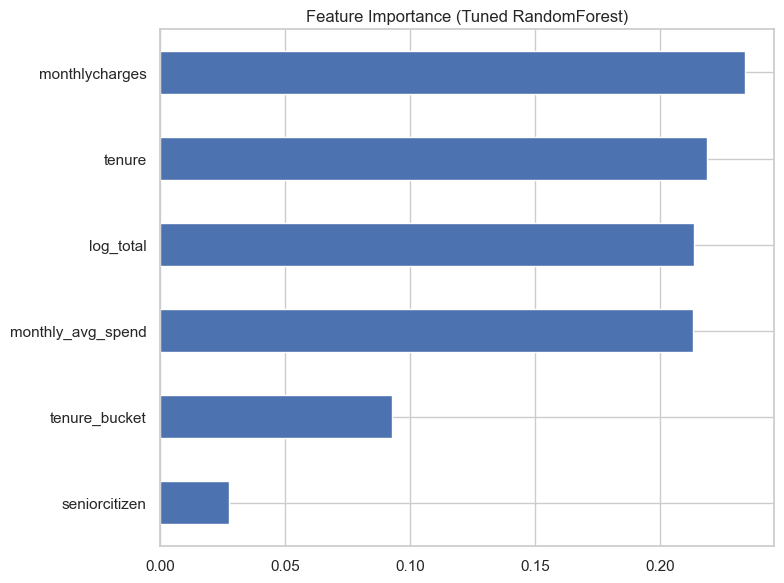

In [21]:
# 11) Feature importance (from tuned model)
feat_names = X_eng.columns.tolist()
feat_imp = pd.Series(best.feature_importances_, index=feat_names).sort_values(ascending=False)
print("\nTop 10 important features (tuned model):")
display(feat_imp.head(10))

# Plot and save feature importance
plt.figure(figsize=(8,6))
feat_imp.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Feature Importance (Tuned RandomForest)")
plt.tight_layout()
plt.savefig("feature_importance_tuned_rf.png")
plt.show()

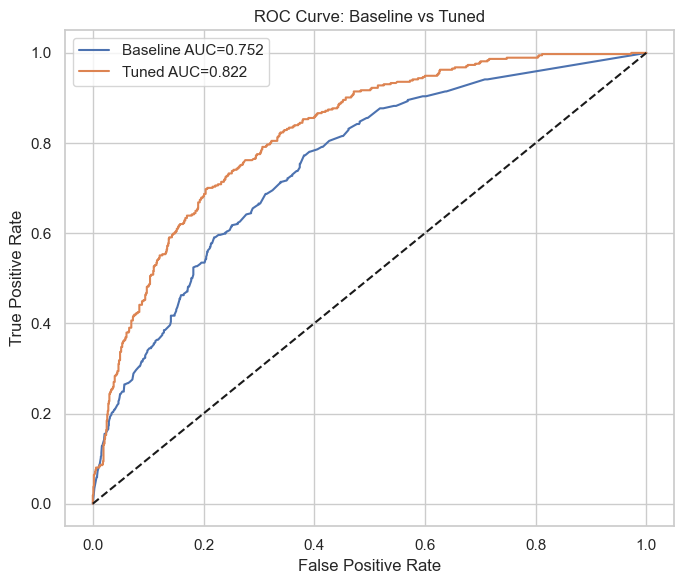

In [22]:
## 12) ROC curves (baseline vs tuned)
fpr_b, tpr_b, _ = roc_curve(yb_test, yb_prob)
fpr_e, tpr_e, _ = roc_curve(ye_test, ye_prob)

plt.figure(figsize=(7,6))
plt.plot(fpr_b, tpr_b, label=f'Baseline AUC={roc_auc_score(yb_test,yb_prob):.3f}' if len(np.unique(yb_test))>1 else 'Baseline')
plt.plot(fpr_e, tpr_e, label=f'Tuned AUC={roc_auc_score(ye_test,ye_prob):.3f}' if len(np.unique(ye_test))>1 else 'Tuned')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Baseline vs Tuned')
plt.legend()
plt.tight_layout()
plt.savefig("roc_comparison.png")
plt.show()


In [23]:
# 13) Save models & results for portfolio
os.makedirs("model_outputs", exist_ok=True)
joblib.dump(rf_base, "model_outputs/rf_baseline.joblib")
joblib.dump(best, "model_outputs/rf_tuned.joblib")
comparison.to_csv("model_outputs/model_comparison.csv", index=False)
feat_imp.to_csv("model_outputs/feature_importances_tuned.csv")

print("\nSaved models and results to 'model_outputs' folder.")


Saved models and results to 'model_outputs' folder.


In [24]:
# 14) Quick summary text to copy to portfolio
acc_before = round(100*comparison.loc[0,'Accuracy'],2)
acc_after = round(100*comparison.loc[1,'Accuracy'],2)
f1_before = round(100*comparison.loc[0,'F1'],2)
f1_after = round(100*comparison.loc[1,'F1'],2)

summary_lines = [
    f"Baseline accuracy improved from {acc_before}% to {acc_after}% after adding engineered features and tuning.",
    f"F1 improved from {f1_before}% to {f1_after}%.",
    "Top features: " + ", ".join(feat_imp.head(5).index.tolist())
]

print("\n--- Quick Portfolio Summary ---")
for line in summary_lines:
    print("-", line)


--- Quick Portfolio Summary ---
- Baseline accuracy improved from 73.95% to 78.85% after adding engineered features and tuning.
- F1 improved from 48.09% to 53.0%.
- Top features: monthlycharges, tenure, log_total, monthly_avg_spend, tenure_bucket
